In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
X_train = np.load('/content/drive/My Drive/Examen_DL/data/X_train_KDEF-emotions.npy')
Y_train = np.load('/content/drive/My Drive/Examen_DL/data/Y_train_KDEF-emotions.npy')
X_valid = np.load('/content/drive/My Drive/Examen_DL/data/X_valid_KDEF-emotions.npy')
Y_valid = np.load('/content/drive/My Drive/Examen_DL/data/Y_valid_KDEF-emotions.npy')

In [3]:
# ==========================================> emotions keys()
emo_dict = {0: 'happy', 1: 'sad', 2: 'surprise', 
            3: 'fear', 4: 'disgust-contempt', 5: 'anger'}

In [4]:
#Set image size because the image are too large
IMAGE_SIZE = [200,200]
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE+[3],
    weights='imagenet',
    include_top=False)

ptm.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [5]:
#map the data into features vectors
K = len(emo_dict) #number of classes
x = AveragePooling2D()(ptm.output)
x = Flatten()(x)
#x = Dense(K,activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=x)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [6]:
from tensorflow.keras.layers import Dropout

feat = model.predict(np.random.random([1]+IMAGE_SIZE+[3]))
D = feat.shape[1]

#Modelo de red neuronal para clasificación binaria
i = Input(shape=(D,))
#x = Dense(1000, activation='relu')(i)
x = Dense(4096, activation='relu')(i)
x = Dropout(0.2)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation='softmax')(x)

emo_model = Model(i ,x)

emo_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)


In [7]:
r = emo_model.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid,Y_valid)
)

Epoch 1/10
27/27 [==============================] - 37s 1s/step - loss: 9.6827 - accuracy: 0.2177 - val_loss: 1.5658 - val_accuracy: 0.3571
Epoch 2/10
27/27 [==============================] - 36s 1s/step - loss: 1.4618 - accuracy: 0.3904 - val_loss: 1.2622 - val_accuracy: 0.4762
Epoch 3/10
27/27 [==============================] - 37s 1s/step - loss: 1.1882 - accuracy: 0.4991 - val_loss: 1.1233 - val_accuracy: 0.5274
Epoch 4/10
27/27 [==============================] - 36s 1s/step - loss: 1.0291 - accuracy: 0.5679 - val_loss: 1.0460 - val_accuracy: 0.5774
Epoch 5/10
27/27 [==============================] - 37s 1s/step - loss: 0.9234 - accuracy: 0.6144 - val_loss: 0.9725 - val_accuracy: 0.6393
Epoch 6/10
27/27 [==============================] - 36s 1s/step - loss: 0.7788 - accuracy: 0.6909 - val_loss: 0.9521 - val_accuracy: 0.6238
Epoch 7/10
27/27 [==============================] - 36s 1s/step - loss: 0.7088 - accuracy: 0.7242 - val_loss: 0.9078 - val_accuracy: 0.6500
Epoch 8/10
27/27 [==

In [8]:
p = emo_model.predict(X_valid)
pred = np.argmax(p, axis=1)

Y_valid = Y_valid.astype(int)

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

#Definición para el calculo de metricas multi-clase
def calculo_metricas(CM, emociones):
    
    emocion = []
    TruPos = []
    FalPos = []
    FalNeg = []
    TruNeg = []
    acc = []
    prec = []
    recall = []
    f1 = []
    
    total = np.sum(CM)
    
    for i in range(len(emociones)):
       
        TP = CM[i][i]
        FP = sum(CM[:,i])-TP
        FN = sum(CM[i,:])-TP
        TN = total - TP-FN-FP
        a = (TP+TN)/(TP+TN+FN+FP)
        p = TP/(TP+FP)
        r = TP/(TP+FN)
        f = 2*(r*p)/(r+p)
        
        emocion.append(emociones[i])
        TruPos.append(TP)
        FalPos.append(FP)
        TruNeg.append(TN)
        acc.append(a)
        prec.append(p)
        recall.append(r)
        f1.append(f)
    
    metricas = pd.DataFrame()
    metricas['Emociones']=emocion
    metricas['Accuracy']=acc
    metricas['Precision']=prec
    metricas['Recall']=recall
    metricas['F1-Score']=f1
    
    return metricas

def graf_confusion_matrix(CM, emociones,emb):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(CM,annot=True,fmt='',xticklabels=emociones,yticklabels=emociones, ax=ax, cmap='Blues');
    ax.set_title('Matriz de confusión '+emb);
    ax.set_xlabel('Valores Predecidos');
    ax.set_ylabel('Valores Verdaderos');
    
def graficar_historia_entrenamiento(log):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(log.history['val_loss'], label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(log.history['val_accuracy'], label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    #ax2.set_ylim((0.0, 1.0))
    #for ax in axes: ax.legend()

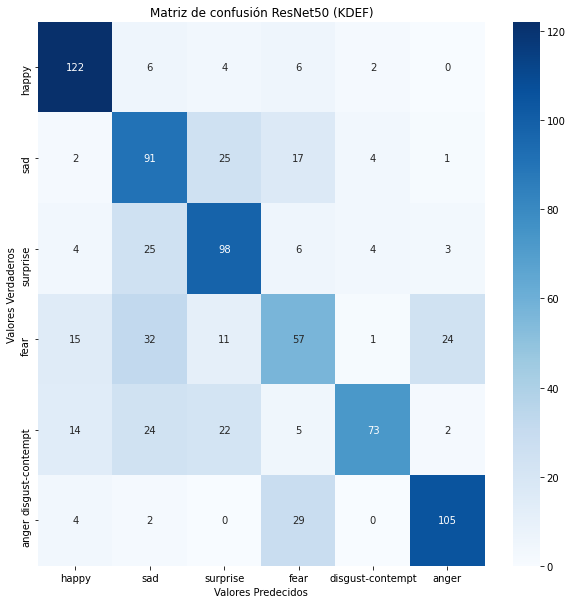

In [11]:
emo_dict = {0: 'happy', 1: 'sad', 2: 'surprise', 3: 'fear', 4: 'disgust-contempt', 5: 'anger'}
emociones_1 = list(emo_dict.values())

CM_ResNet = confusion_matrix(Y_valid, pred)
graf_confusion_matrix(CM_ResNet, emociones_1 ,'ResNet50 (KDEF)')

In [12]:
m1 = calculo_metricas(CM_ResNet, emociones_1)
m1

,Emociones,Accuracy,Precision,Recall,F1-Score
0,happy,0.932143,0.757764,0.871429,0.810631
1,sad,0.835714,0.505556,0.650000,0.568750
2,surprise,0.876190,0.612500,0.700000,0.653333
3,fear,0.826190,0.475000,0.407143,0.438462
4,disgust-contempt,0.907143,0.869048,0.521429,0.651786
5,anger,0.922619,0.777778,0.750000,0.763636


In [13]:
emo_model.save('mod_ResNet50_emotions_KDEF_tst01.h5')